## Data loading - YLFW Benchmark
Source: https://github.com/JessyFrish/YLFW_Links?tab=readme-ov-file

Make suitable for ArcFace and MagFace (112x112) and FaceNet (160x160)

### Data folder structure and metadata


In [2]:
# Load packages

# Common
import pandas as pd
import numpy as np
import os
import cv2 as cv
from IPython.display import clear_output as cls
import json

# Data
from glob import glob

# Data Visuaalization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


### Descriptive analysis of data

#### Data concatenation

In [3]:
## Create dataframe

# Define the path to the raw data directory
raw_data_path = '../data/raw_full/'

# Initialize lists to store image characteristics
img_names = []
id_class = []
ethnicities = []

# Iterate through the directories of each ethnicity (e.g., 'Asian')
ethnicities_list = os.listdir(raw_data_path + 'YLFW/data_aligned') 
#To ensure DS Store is not included. DELETE files with '.'
ethnicities_list = [x for x in ethnicities_list if not x.startswith(".")]

for ethnicity in ethnicities_list:
    ethnicity_col = ethnicity.split('_')[0]
    id = int(ethnicity.split('_')[1:][0])
    ethnicity_dir = os.path.join(raw_data_path + 'YLFW/data_aligned', ethnicity)
    if os.path.isdir(ethnicity_dir):
        # Iterate through image files in the ethnicity directory
        for img_name in os.listdir(ethnicity_dir):
            # Append image characteristics to lists
            img_name = img_name.split('.')[0]
            img_names.append(img_name)
            ethnicities.append(ethnicity_col)
            id_class.append(id)


# Create a DataFrame from the lists
data = {'img_name': img_names, 'ethnicity': ethnicities, 'id_class': id_class} 
df = pd.DataFrame(data)

# Display the DataFrame
print("len of df", len(df))
print("\nisna?", df.isna().sum())  
df.head()


len of df 9810

isna? img_name     0
ethnicity    0
id_class     0
dtype: int64


,img_name,ethnicity,id_class
0,African_754_1,African,754
1,African_566_0,African,566
2,Caucasian_1390_10,Caucasian,1390
3,Caucasian_1390_3,Caucasian,1390
4,African_102_0,African,102


In [4]:
# Read the JSON file into a JSON variable
with open('../data/raw/age_estimation/output_data_precroped_all_age.json', 'r') as file:
    json_data = json.load(file)

# Convert the JSON data to a DataFrame
age_df = pd.DataFrame.from_dict(json_data, orient='index', columns=['Age'])
# Convert the 'Age' column to numeric
age_df['Age'] = pd.to_numeric(age_df['Age'])
age_df.reset_index(inplace=True)
age_df.columns = ['img_name', 'Age']

print("len of age df",len(age_df))
print("isna", age_df.isna().sum())
age_df.head()


len of age df 9810
isna img_name      0
Age         581
dtype: int64


,img_name,Age
0,Caucasian_1008_18,8.0
1,Asian_225_72,11.0
2,Asian_238_1,3.0
3,Caucasian_1110_17,4.0
4,Caucasian_364_12,2.0


In [5]:
# Concatenate dataframes
final_df = pd.merge(age_df, df, on='img_name', how='inner')
print("len of final df",len(final_df))
print("isna?",final_df.isna().sum())
final_df.head()

len of final df 9810
isna? img_name       0
Age          581
ethnicity      0
id_class       0
dtype: int64


,img_name,Age,ethnicity,id_class
0,Caucasian_1008_18,8.0,Caucasian,1008
1,Asian_225_72,11.0,Asian,225
2,Asian_238_1,3.0,Asian,238
3,Caucasian_1110_17,4.0,Caucasian,1110
4,Caucasian_364_12,2.0,Caucasian,364


In [6]:
#duplicates?
final_df["img_name"].duplicated().sum()

0

In [7]:
final_df.duplicated().sum()

0

In [8]:
age_df.isna().sum()

img_name      0
Age         581
dtype: int64

In [9]:
isna_age = final_df[final_df.Age.isna()]

Relatively balanced with Caucasian being the most represented - We remove

In [10]:
isna_age.ethnicity.value_counts(normalize=True)

ethnicity
Caucasian    0.376936
African      0.237522
Asian        0.234079
Indian       0.151463
Name: proportion, dtype: float64

In [11]:
final_df.ethnicity.value_counts(normalize=True)

ethnicity
Caucasian    0.285525
Asian        0.268705
African      0.234251
Indian       0.211519
Name: proportion, dtype: float64

In [12]:
# Remove NaN values
final_df.dropna(inplace=True)
print("len of final df",len(final_df))

len of final df 9229


In [13]:
# Ensure 'Age' is of type integer
final_df['Age'] = final_df['Age'].astype(int)

# Define the age groups and corresponding labels
age_bins = [0, 4, 7, 10, 13, 16, 19]  # adding one more bin for 16-18
age_labels = ['0-3', '4-6', '7-9', '10-12', '13-15', '16-18']

# Update the DataFrame with age groupings
final_df['children_agegroup'] = pd.cut(final_df['Age'], bins=age_bins, labels=age_labels, right=False)


In [14]:
final_df.head() 

,img_name,Age,ethnicity,id_class,children_agegroup
0,Caucasian_1008_18,8,Caucasian,1008,7-9
1,Asian_225_72,11,Asian,225,10-12
2,Asian_238_1,3,Asian,238,0-3
3,Caucasian_1110_17,4,Caucasian,1110,4-6
4,Caucasian_364_12,2,Caucasian,364,0-3


#### Data distributions
(Evt efter age groups)

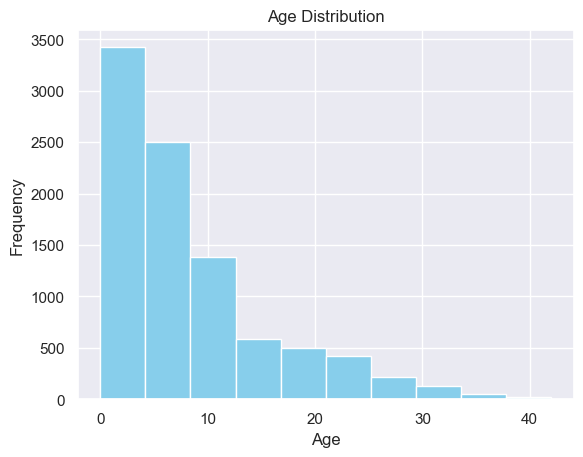

In [15]:
plt.hist(final_df['Age'], color='skyblue')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()


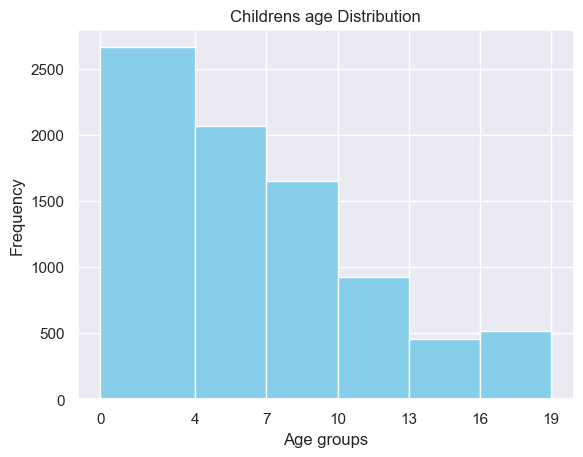

In [16]:
# Define bin edges for each group of 3 years
bin_edges = [0, 4, 7, 10, 13, 16, 19]
plt.hist(final_df['Age'], bins=age_bins, color='skyblue')
plt.xticks(bin_edges)
plt.xlabel('Age groups')
plt.ylabel('Frequency')
plt.title('Childrens age Distribution')
plt.show()


In [41]:
# Define bin edges for each group of 3 years
plt.hist(final_df['ethnicity'], bins=4, color='skyblue')
plt.xticks(final_df['ethnicity'])
plt.xlabel('Ethnicity')
plt.ylabel('Frequency')
plt.title('Ethnicity composition')
plt.show()


KeyboardInterrupt: 

#### Save df

In [17]:
final_df["im_id"] = final_df["img_name"].apply(lambda x: "_".join(x.split("_")[:2]))
final_df

,img_name,Age,ethnicity,id_class,children_agegroup,im_id
0,Caucasian_1008_18,8,Caucasian,1008,7-9,Caucasian_1008
1,Asian_225_72,11,Asian,225,10-12,Asian_225
2,Asian_238_1,3,Asian,238,0-3,Asian_238
3,Caucasian_1110_17,4,Caucasian,1110,4-6,Caucasian_1110
4,Caucasian_364_12,2,Caucasian,364,0-3,Caucasian_364
...,...,...,...,...,...,...
9802,Indian_132_0,11,Indian,132,10-12,Indian_132
9805,Caucasian_367_13,8,Caucasian,367,7-9,Caucasian_367
9806,Asian_19_28,29,Asian,19,NaN,Asian_19
9807,Asian_554_5,3,Asian,554,0-3,Asian_554


In [18]:
final_df.to_csv('../data/raw_full/raw_ylfw_df.csv', index=False)

#### OBS Overvej om man skal sænke alle aldre højere end 18 i YLFW til 18..

Check age group difference between each id. 

In [86]:
# Per image_name
final_df["im_id"] = final_df["img_name"].apply(lambda x: "_".join(x.split("_")[:2]))
age_df.head()

,img_name,Age,im_id
0,Caucasian_1008_18,8.0,Caucasian_1008
1,Asian_225_72,11.0,Asian_225
2,Asian_238_1,3.0,Asian_238
3,Caucasian_1110_17,4.0,Caucasian_1110
4,Caucasian_364_12,2.0,Caucasian_364


In [87]:
# Groupby and get both std and counts

final_df.groupby("im_id").agg({'Age': ['min', 'max','std', 'count']}).sort_values(by=('Age', 'std'), ascending=False).head(10)

Age                    
              min max       std count
im_id                                
African_0       7  18  7.778175     2
African_1       2   5  2.121320     2
Caucasian_204   1   5  2.049390     5
Asian_386       8  13  1.690309     8
Caucasian_386   2   4  1.154701     4
Asian_14        2   4  0.707107     5
Indian_80       5   6  0.707107     2
Indian_98       3   4  0.707107     2
Caucasian_604   0   1  0.577350     3
Indian_224     14  14       NaN     1

In [90]:
final_df[final_df["im_id"] == "Asian_386"]

,img_name,Age,ethnicity,id_class,children_agegroup,im_id
1,Asian_386_43,9,Asian,386,7-9,Asian_386
3,Asian_386_2,9,Asian,386,7-9,Asian_386
9,Asian_386_30,10,Asian,386,10-12,Asian_386
10,Asian_386_40,9,Asian,386,7-9,Asian_386
15,Asian_386_27,8,Asian,386,7-9,Asian_386
16,Asian_386_38,13,Asian,386,13-15,Asian_386
24,Asian_386_42,10,Asian,386,10-12,Asian_386
28,Asian_386_3,12,Asian,386,10-12,Asian_386


In [88]:
# Per image_name
age_df["im_id"] = age_df["img_name"].apply(lambda x: "_".join(x.split("_")[:2]))
age_df.head()

,img_name,Age,im_id
0,Caucasian_1008_18,8.0,Caucasian_1008
1,Asian_225_72,11.0,Asian_225
2,Asian_238_1,3.0,Asian_238
3,Caucasian_1110_17,4.0,Caucasian_1110
4,Caucasian_364_12,2.0,Caucasian_364


In [89]:
# Groupby and get both std and counts

age_df.groupby("im_id").agg({'Age': ['min', 'max','std', 'count']}).sort_values(by=('Age', 'std'), ascending=False).head(10)

Age                       
                min   max        std count
im_id                                     
Indian_87       0.0  30.0  21.213203     2
Asian_620       2.0  29.0  19.091883     2
Asian_570       2.0  35.0  18.502252     3
African_44      6.0  32.0  18.384776     2
Asian_96        0.0  26.0  18.384776     2
Indian_25       7.0  32.0  17.677670     2
Caucasian_1127  7.0  31.0  16.970563     2
African_343     9.0  32.0  16.263456     2
African_550     3.0  25.0  15.556349     2
Indian_109      6.0  33.0  15.307950     3